# Titanic - Machine Learning from Disaster

![](https://storage.googleapis.com/kaggle-competitions/kaggle/3136/logos/header.png)

# Table of Contents

* [Introduction](#introduction)
* [House Keeping](#house)
* [Exploratory Data Analysis](#EDA)
* [Feature Selection](#feature)
* [Final Processing](#final)
* [Modelling](#model)
* [Model Tuning - Hyperparameter GridSearch](#tuning)
* [Model Performance](#performance)
* [To Do in future versions!](#future)

# Introduction <a id="introduction"></a>

Analysis, Feature Engineering and Modelling of the titanic dataset from [Kaggle](https://www.kaggle.com/competitions/titanic/overview).

In this notebook is my first attempt of a thorough analysis of the titanic dataset. The goal was to predict survivors of the tragic sinking of the titanic based passenger information such as age, sex and socio-economic status.

I tried several models, both with and without tuning to both improve my result and learn along the way.

**Best performing model: 83.4%**

**Hope you enjoy, let me know how I can improve, and if you liked it, an upvote would help me out alot!**

## Columns in the dataset

The columns present in the dataset are as follows: 
1. **PassengerId**: This column assigns a unique identifier for each passenger.
2. **Survived**: Specifies whether the given passenger survived or not (1 - survived, 0 - didn't survive)
3. **Pclass**: The passenger's class. (1 = Upper Deck, 2 = Middle Deck, 3 = Lower Deck)
4. **Name**: The name of the passenger. 
5. **Sex**: The sex of the passenger (male, female)
6. **Age**: The age of the passenger in years. If the age is estimated, is it in the form of xx.5. 
7. **SibSp**: How many siblings or spouses the passenger had on board with them. Sibling = brother, sister, stepbrother, stepsister and Spouse = husband, wife (mistresses and fiancés were ignored)
8. **Parch**: How many parents or children the passenger had on boad with them. Parent = mother and father, child = daughter, son, stepdaughter and stepson and some children travelled only with a nanny, therefore parch=0 for them.
9. **Ticket**: The ticket of the passenger. 
10. **Fare**: The fare amount paid by the passenger for the trip. 
11. **Cabin**: The cabin in which the passenger stayed. 
12. **Embarked**: The place from which the passenger embarked (S, C, Q)

# House Keeping <a id="house"></a>

## Import Libraries

In [1]:
from IPython.display import FileLink # add stuff to file
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("YlGnBu")

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV 

from sklearn.metrics import classification_report

## Dataset load and summary

In [2]:
# load datasets
df_train = pd.read_csv('/kaggle/input/titanic/train.csv')
df_test = pd.read_csv('/kaggle/input/titanic/test.csv')
df_gender_submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

# mark train and test sets for future split
df_train['train_test'] = 1
df_test['train_test'] = 0
df_test['Survived'] = np.NaN

#combine to a single dataframe with all data for feature engineering
df_all = pd.concat([df_train, df_test])

# print dataset shape and columns
print(f'''
Train Dataset:
Loaded train dataset with shape {df_train.shape} ({df_train.shape[0]} rows and {df_train.shape[1]} columns) and column names: 
{df_train.columns.to_list()}

Test Dataset:
Loaded test dataset with shape {df_test.shape} ({df_test.shape[0]} rows and {df_test.shape[1]} columns) and column names:
{df_test.columns.to_list()}')

Sample Submission Dataset:
Loaded sample submission dataset with shape {df_gender_submission.shape} ({df_gender_submission.shape[0]} rows and {df_gender_submission.shape[1]} columns) and column names:
{df_gender_submission.columns.to_list()}
''')


Train Dataset:
Loaded train dataset with shape (891, 13) (891 rows and 13 columns) and column names: 
['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test']

Test Dataset:
Loaded test dataset with shape (418, 13) (418 rows and 13 columns) and column names:
['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test', 'Survived']')

Sample Submission Dataset:
Loaded sample submission dataset with shape (418, 2) (418 rows and 2 columns) and column names:
['PassengerId', 'Survived']



## Train dataset

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
 12  train_test   891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [5]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,train_test
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,891.0
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208,1.0
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429,0.0
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000,1.0
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400,1.0
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200,1.0
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000,1.0
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200,1.0


## Initial thoughs

* The **PassengerID** column shouldnt provide any useful information about survival, so it should be dropped.
* The **Fare** column looks very volatile on the high end, Q3 (75%) = 31 and MAX = 512, maybe outliers?
* There are null values in **Age**, **Cabin** and **Embarked**, these should be fixed, maybe **Age** and **Embarked** are missing data and **Cabin** is simply due to not every passenger having a **Cabin**
* Both numerical and categorical columns. They should be examined further and either scaled or one hot encoded to improve model performance

# Exploratory Data Analysis <a id="EDA"></a>

## Survival ratio


There were 342 survivors and 549 mortalities in the train set.
Making the chance of survival 38.38383838383838%



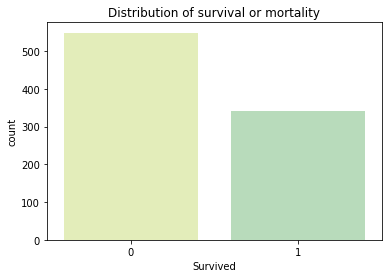

In [6]:
df_survived = df_train['Survived']

print(f'''
There were {df_survived.value_counts()[1]} survivors and {df_survived.value_counts()[0]} mortalities in the train set.
Making the chance of survival {df_survived.value_counts()[1] / (df_survived.value_counts()[1] + df_survived.value_counts()[0]) * 100}%
''')

sns.countplot(x = df_survived)
plt.title('Distribution of survival or mortality')
plt.show()

## Name

In [7]:
# Extract titles
df_train['Title'] = df_train['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0]

# List most frequent titles
(df_train['Title'].value_counts()
                  .to_frame()
                  .reset_index()
                  .iloc[:6]
                  .rename(columns={'index':'Title', 'Title':'Frequency'}))

,Title,Frequency
0,Mr,517
1,Miss,182
2,Mrs,125
3,Master,40
4,Dr,7
5,Rev,6


## Ticket Class


Passengers were split into three Ticket Classes and hereby the placement on the ship deck:
There were 216 people on the upper deck.
There were 184 people on the middle deck.
There were 491 people on the lower deck



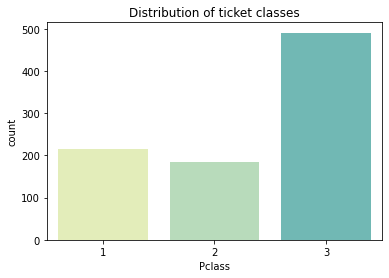

In [8]:
df_pclass = df_train['Pclass']

print(f'''
Passengers were split into three Ticket Classes and hereby the placement on the ship deck:
There were {df_pclass.value_counts().sort_index()[1]} people on the upper deck.
There were {df_pclass.value_counts().sort_index()[2]} people on the middle deck.
There were {df_pclass.value_counts().sort_index()[3]} people on the lower deck
''')

sns.countplot(x = df_pclass)
plt.title('Distribution of ticket classes')
plt.show()

## Passenger sex


There were 577 males aboard.
There were 314 females aboard.



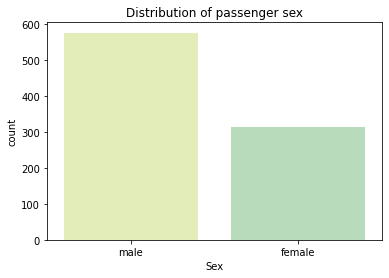

In [9]:
df_sex = df_train['Sex']

print(f'''
There were {df_sex.value_counts().sort_index()[1]} males aboard.
There were {df_sex.value_counts().sort_index()[0]} females aboard.
''') 

sns.countplot(x = df_sex)
plt.title('Distribution of passenger sex')
plt.show()

## Passenger age


There were 278 passenges under the age of 25.
There were 428 passengers between the age of 25 and 65.
There were 8 passenges older than 65.



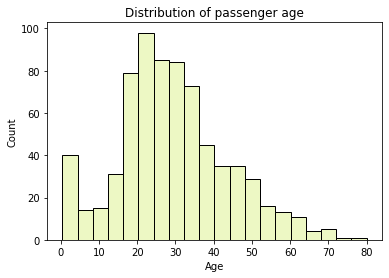

In [10]:
df_age = df_train['Age']

print(f'''
There were {np.count_nonzero(df_age < 25)} passenges under the age of 25.
There were {np.count_nonzero((df_age >= 25) & (df_age <= 65))} passengers between the age of 25 and 65.
There were {np.count_nonzero(df_age > 65)} passenges older than 65.
''') 

sns.histplot(data = df_age)
plt.title('Distribution of passenger age')
plt.show()

## Number of siblings/spouses

There were 608 passengers with no siblings or spouses.


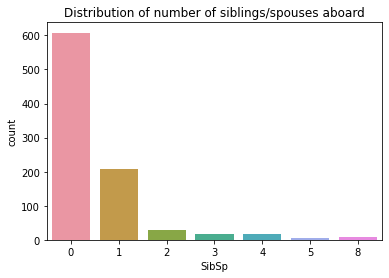

In [11]:
df_sibsp = df_train['SibSp']

print(f'There were {df_sibsp.value_counts().sort_index()[0]} passengers with no siblings or spouses.')

sns.countplot(x = df_sibsp)
plt.title('Distribution of number of siblings/spouses aboard')
plt.show()

## Number of parents/children

There were 678 passengers with no parents or children.


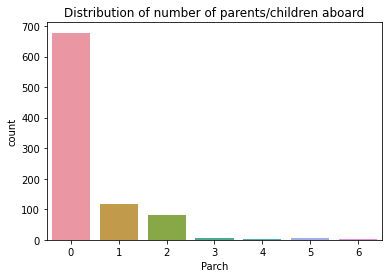

In [12]:
df_parch = df_train['Parch']

print(f'There were {df_parch.value_counts().sort_index()[0]} passengers with no parents or children.')

sns.countplot(x = df_parch)
plt.title('Distribution of number of parents/children aboard')
plt.show()

## Tickets


There were 547 passengers who bought their ticket alone.
There were 134 passengers who bought tickets together.



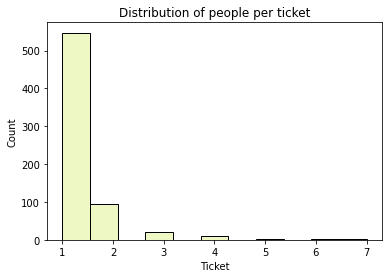

In [13]:
df_ticket = df_train['Ticket']

print(f'''
There were {np.count_nonzero(df_ticket.value_counts() == 1)} passengers who bought their ticket alone.
There were {np.count_nonzero(df_ticket.value_counts() > 1)} passengers who bought tickets together.
''') 

sns.histplot(data = df_ticket.value_counts())
plt.title('Distribution of people per ticket')
plt.show()

## Fare


There were 336 passengers payed less than 10 dollars for their ticket.
There were 395 passengers payed between 10 and 50 dollars for their ticket.
There were 160 passengers payed more than 50 dollars for their ticket.



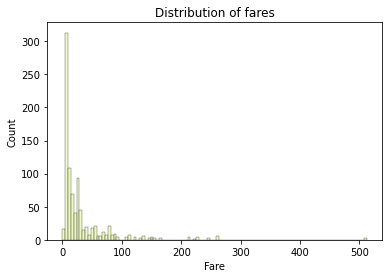

In [14]:
df_fare = df_train['Fare']

print(f'''
There were {np.count_nonzero(df_fare < 10)} passengers payed less than 10 dollars for their ticket.
There were {np.count_nonzero((df_fare >= 10) & (df_fare <= 50))} passengers payed between 10 and 50 dollars for their ticket.
There were {np.count_nonzero(df_fare > 50)} passengers payed more than 50 dollars for their ticket.
''') 


sns.histplot(data = df_fare)
plt.title('Distribution of fares')
plt.show()

## Cabin


There were 204 passengers who had a cabin. 
There were 687 passengers who did not have a cabin.



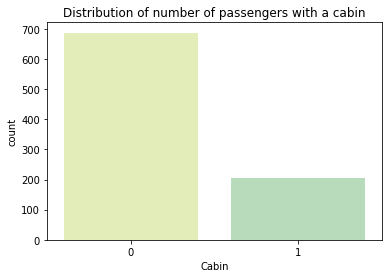

In [15]:
df_cabin = df_train['Cabin'].apply(lambda x: 1 if not pd.isnull(x) else 0)

print(f'''
There were {df_cabin.value_counts().sort_index()[1]} passengers who had a cabin. 
There were {df_cabin.value_counts().sort_index()[0]} passengers who did not have a cabin.
''') 

sns.countplot(x = df_cabin)
plt.title('Distribution of number of passengers with a cabin')
plt.show()

## Port of Embarkation


There were 644 passengers boarding the ship at Southampton.
There were 168 passengers boarding the ship at Cherbourg.
There were 77 passengers boarding the ship at Queenstown.



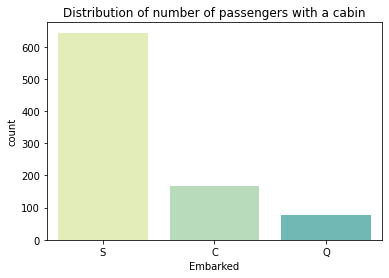

In [16]:
df_port = df_train['Embarked']

print(f'''
There were {df_port.value_counts().sort_index()[2]} passengers boarding the ship at Southampton.
There were {df_port.value_counts().sort_index()[0]} passengers boarding the ship at Cherbourg.
There were {df_port.value_counts().sort_index()[1]} passengers boarding the ship at Queenstown.
''') 

sns.countplot(x = df_port)
plt.title('Distribution of number of passengers with a cabin')
plt.show()

## Survival rate factors

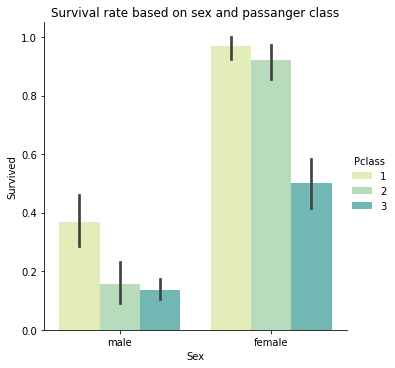

In [17]:
sns.catplot(data=df_train, x="Sex", y="Survived", hue="Pclass", kind="bar")
plt.title('Survival rate based on sex and passanger class')
plt.show()

# Feature Selection <a id="feature"></a>

In [18]:
# change cabin names and numbers to cabin yes or no

df_train['Cabin'] = df_train['Cabin'].apply(lambda x: 1 if not pd.isnull(x) else 0)

# change male/female to 0 and 1

df_train.loc[df_train['Sex'] == 'male', 'Sex'] = 0
df_train.loc[df_train['Sex'] == 'female', 'Sex'] = 1

# One-Hot encode Embarkation (done with pd.get_dummies() further down)

df_train.loc[df_train['Embarked'] == 'S', 'embarked_Southampton'] = 1
df_train.loc[df_train['Embarked'] == 'C', 'embarked_Cherbough'] = 1
df_train.loc[df_train['Embarked'] == 'Q', 'embarked_Queenstown'] = 1

df_train = df_train.drop('Embarked', axis = 1)

df_train = df_train.replace(np.nan, 0)

In [19]:
# Corelation matrix of numerical categories
(df_train[[
    'PassengerId', 
    'Survived', 
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Cabin',
    'Pclass',
    'embarked_Southampton',
    'embarked_Cherbough',
    'embarked_Queenstown']].corr())

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin,Pclass,embarked_Southampton,embarked_Cherbough,embarked_Queenstown
PassengerId,1.000000,-0.005007,0.038125,-0.057527,-0.001652,0.012658,0.019919,-0.035144,0.022148,-0.001205,-0.033606
Survived,-0.005007,1.000000,0.010539,-0.035322,0.081629,0.257307,0.316912,-0.338481,-0.155660,0.168240,0.003650
Age,0.038125,0.010539,1.000000,-0.184664,-0.048786,0.135516,0.269360,-0.361353,0.140578,0.001246,-0.237586
SibSp,-0.057527,-0.035322,-0.184664,1.000000,0.414838,0.159651,-0.040460,0.083081,0.070941,-0.059528,-0.026354
Parch,-0.001652,0.081629,-0.048786,0.414838,1.000000,0.216225,0.036987,0.018443,0.063036,-0.011069,-0.081228
Fare,0.012658,0.257307,0.135516,0.159651,0.216225,1.000000,0.482075,-0.549500,-0.166603,0.269335,-0.117216
Cabin,0.019919,0.316912,0.269360,-0.040460,0.036987,0.482075,1.000000,-0.725541,-0.110087,0.208528,-0.129572
Pclass,-0.035144,-0.338481,-0.361353,0.083081,0.018443,-0.549500,-0.725541,1.000000,0.081720,-0.243292,0.221009
embarked_Southampton,0.022148,-0.155660,0.140578,0.070941,0.063036,-0.166603,-0.110087,0.081720,1.000000,-0.778359,-0.496624
embarked_Cherbough,-0.001205,0.168240,0.001246,-0.059528,-0.011069,0.269335,0.208528,-0.243292,-0.778359,1.000000,-0.148258


Text(0.5, 1.0, 'Heatmap for correlation between columns of training data')

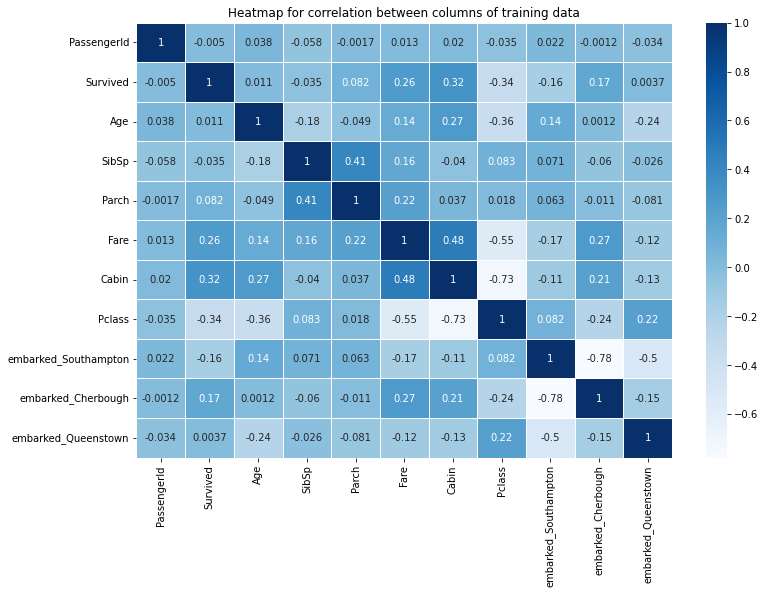

In [20]:
# Heatmap of correlation matrix for training data columns

fig, ax = plt.subplots(figsize=(12,8)) 

sns.heatmap((df_train[[
            'PassengerId', 
            'Survived', 
            'Age',
            'SibSp',
            'Parch',
            'Fare',
            'Cabin',
            'Pclass',
            'embarked_Southampton',
            'embarked_Cherbough',
            'embarked_Queenstown'
            ]].corr()),
            linewidths=1,
            cmap=plt.cm.Blues, 
            annot=True,
            ax=ax)

plt.title('Heatmap for correlation between columns of training data')

# Final Processing <a id="final"></a>

In [21]:
df_all.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,train_test
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [22]:
# impute nulls for continuous data 
df_all.Age = df_all.Age.fillna(df_train.Age.median())
df_all.Fare = df_all.Fare.fillna(df_train.Fare.median())

# drop null the two null Embarked values
df_all.dropna(subset=['Embarked'],inplace = True)

# change cabin names and numbers to cabin yes or no
df_all['Cabin'] = df_all['Cabin'].apply(lambda x: 1 if not pd.isnull(x) else 0)

# extract titles
df_all['Title'] = df_all['Name'].str.split(',', expand=True)[1].str.split('.', expand=True)[0]

# drop unneeded columns
df_all = (df_all.drop([
                    'PassengerId',
                    'Name',
                    'Title',
                    'Ticket',
                    'Name'],
                    axis = 1
                    ))

df_all['Pclass'] = df_all['Pclass'].astype(str)

# make dummies (OneHotEncode) categorical variables
df_all_dummies = pd.get_dummies(df_all[['Pclass', 
                                        'Sex', 
                                        'Age',
                                        'SibSp', 
                                        'Parch', 
                                        'Fare', 
                                        'Cabin', 
                                        'Embarked', 
                                        'train_test']])

# Scale data
scaler = StandardScaler()
(df_all_dummies[['Age', 
                 'SibSp', 
                 'Parch', 
                 'Fare']]) = (scaler.fit_transform(df_all_dummies[['Age', 
                                                                  'SibSp', 
                                                                  'Parch', 
                                                                  'Fare']]))

# resplit into train and test sets
X_train = df_all_dummies[df_all_dummies.train_test == 1].drop(['train_test'], axis =1)
X_test = df_all_dummies[df_all_dummies.train_test == 0].drop(['train_test'], axis =1)
y_train = df_all[df_all['train_test'] == 1]['Survived']
y_test = df_all[df_all['train_test'] == 0]['Survived']

print(f'Before training models our train set has {X_train.shape} rows and columns and our test set has {X_test.shape} rows and columns.')

Before training models our train set has (889, 13) rows and columns and our test set has (418, 13) rows and columns.


# Modelling <a id="model"></a>

We have a preprocessed and model ready dataset, now to chose the right model. We are trying to predict which passangers survived the titanic sinkage, so most of the models we are testing, are **classification** models.

To get an indication of the best model, I will try several, baseline, models without any tuning. After getting an indication of which model performs best on our dataset, I will use grid search to tune the model hyperparameters to further improve the accuracy.

* [Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) - Naive Bayes models uses Bayes Theorem that offers conditional probability of events taking place.
* [Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) - Decision Trees create a series of decisions to classify data based on the rules learned from the dataset.
* [KNeighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) - Neightbor Classifiers groups data with other data near to it based in a specified k value.
* [Random Forest Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) - Random Forest classifiers fits a number of decision treees on subsamples of the dataset to improve the accuracy and redude over-fitting.
* [Support Vector Classifier (SVC)](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
* [XGBoost Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) - Bootsting Classifiers builds additive models to allow optimization of the downstream models based on loss functions.
* [Voting Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) - Voting Classifier trains different models using the chosen algorithms, returning the majority's vote as the result.

In [23]:
gnb = GaussianNB()

cv = cross_val_score(gnb, 
                     X_train, 
                     y_train, 
                     cv=5)

print(f'{cv}\nAverage: {cv.mean()}')

[0.74719101 0.74719101 0.7752809  0.79775281 0.78531073]
Average: 0.7705452929600711


In [24]:
lr = LogisticRegression(max_iter=2000)

cv = cross_val_score(lr, 
                     X_train, 
                     y_train, 
                     cv=5)

print(f'{cv}\nAverage: {cv.mean()}')

[0.82022472 0.79775281 0.78651685 0.78089888 0.84180791]
Average: 0.8054402336062972


In [25]:
dt = tree.DecisionTreeClassifier(random_state=42)

cv = cross_val_score(dt, 
                     X_train, 
                     y_train, 
                     cv=5)

print(f'{cv}\nAverage: {cv.mean()}')

[0.75280899 0.78089888 0.82022472 0.7247191  0.84180791]
Average: 0.7840919189995557


In [26]:
knn = KNeighborsClassifier()

cv = cross_val_score(knn, 
                     X_train, 
                     y_train, 
                     cv=5)

print(f'{cv}\nAverage: {cv.mean()}')

[0.80337079 0.78089888 0.80898876 0.8258427  0.8079096 ]
Average: 0.805402145623056


In [27]:
rf = RandomForestClassifier(random_state=42)

cv = cross_val_score(rf, 
                     X_train, 
                     y_train, 
                     cv=5)

print(f'{cv}\nAverage: {cv.mean()}')

[0.78089888 0.78651685 0.85393258 0.78089888 0.82485876]
Average: 0.8054211896146766


In [28]:
svc = SVC(probability=True)

cv = cross_val_score(svc, 
                     X_train, 
                     y_train, 
                     cv=5)

print(f'{cv}\nAverage: {cv.mean()}')

[0.8258427  0.81460674 0.80337079 0.81460674 0.86440678]
Average: 0.8245667491906303


In [29]:
xgb = XGBClassifier(random_state = 42)

cv = cross_val_score(xgb, 
                     X_train, 
                     y_train, 
                     cv=5)

print(f'{cv}\nAverage: {cv.mean()}')

[0.79213483 0.81460674 0.84831461 0.79213483 0.86440678]
Average: 0.8223195581793945


In [30]:
voting_clf = VotingClassifier(estimators=[
                                          ('lr', lr), 
                                          ('knn', knn), 
                                          ('rf', rf), 
                                          ('gnb', gnb), 
                                          ('dt', dt), 
                                          ('svc', svc), 
                                          ('xgb', xgb)],
                                          voting='soft'
                                          )

cv = cross_val_score(voting_clf, X_train, y_train, cv=5)

print(f'{cv}\nAverage: {cv.mean()}')

[0.80898876 0.80898876 0.84831461 0.78651685 0.85875706]
Average: 0.8223132101821875


## Baseline submission of best performing model

In [31]:
voting_clf.fit(X_train, y_train)

y_hat_baseline = voting_clf.predict(X_test).astype(int)

baseline_submission = {'PassengerId': df_test.PassengerId, 'Survived': y_hat_baseline}

baseline_submission = pd.DataFrame(data=baseline_submission)

baseline_submission.to_csv('baseline_submission.csv', index=False)

## Baseline model performance

|Model|Baseline Performance|
|--|--|
|Naive Bayes| 77.0%|
|Logistic Regression| 80.5%| 
|Decision Tree Classifier| 78.4%|
|KNN Classifier| 80.5%|
|Random Forest Classifier| 80.5%|
|**Support Vector Classifier**| **82.5%**|
|Xtreme Gradient Boosting| 82.2%|
|Voting Classifier| 82.0%|

# Model Tuning - Hyperparameter GridSearch <a id="tuning"></a>

In [32]:
def model_performance(model, name):
    print(name)
    print(f'Best Score: {model.best_score_}')
    print(f'Best Parameters: {model.best_params_}')    

In [33]:
lr = LogisticRegression()

parameter_grid = {'max_iter' : [2000],
                  'penalty' : ['l1', 'l2'],
                  'C' : np.logspace(-4, 4, 20),
                  'solver' : ['liblinear'
                  ]}

lr_model = GridSearchCV(lr, 
                        param_grid=parameter_grid, 
                        cv=5, 
                        verbose=True, 
                        n_jobs=1)

best_lr_model = lr_model.fit(X_train, y_train)

model_performance(best_lr_model, 'LogisticRegression')

Fitting 5 folds for each of 40 candidates, totalling 200 fits
LogisticRegression
Best Score: 0.8065638291119152
Best Parameters: {'C': 1.623776739188721, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}


In [34]:
knn = KNeighborsClassifier()

parameter_grid = {'n_neighbors' : [3,5,7,9],
                  'weights' : ['uniform', 'distance'],
                  'algorithm' : ['auto', 'ball_tree','kd_tree'],
                  'p' : [1,2]}

knn_model = GridSearchCV(knn, 
                         param_grid=parameter_grid, 
                         cv=5, 
                         verbose=True, 
                         n_jobs=-1)

best_knn_model = knn_model.fit(X_train, y_train)

model_performance(best_knn_model, 'KNN')

Fitting 5 folds for each of 48 candidates, totalling 240 fits
KNN
Best Score: 0.8065257411286739
Best Parameters: {'algorithm': 'auto', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}


In [35]:
svc = SVC(probability=True)

parameter_grid = {'kernel': ['rbf'], 
                   'gamma': [.1,.5,1],
                   'C': [.1, 1, 10]}

svc_model = GridSearchCV(svc, 
                       param_grid=parameter_grid, 
                       cv=5, 
                       verbose=True, 
                       n_jobs=-1)

best_svc_model = svc_model.fit(X_train, y_train)

model_performance(best_svc_model,'SVC')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
SVC
Best Score: 0.8290547832158953
Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In [36]:
rf = RandomForestClassifier(random_state=42)

parameter_grid = {'n_estimators': [100,500], 
                  'bootstrap': [True,False],
                  'max_depth': [10,20,50,75,None],
                  'max_features': ['auto','sqrt'],
                  'min_samples_leaf': [1,2,4],
                  'min_samples_split': [2,5,10]}
                                  
rf_model_randomcv = RandomizedSearchCV(rf, 
                                param_distributions=parameter_grid, 
                                n_iter=50, 
                                cv=5, 
                                verbose=True, 
                                n_jobs=-1)


best_rf_model_randomcv = rf_model_randomcv.fit(X_train, y_train)

model_performance(best_rf_model_randomcv, 'Random Forest')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Random Forest
Best Score: 0.8256903446962482
Best Parameters: {'n_estimators': 500, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 75, 'bootstrap': True}


In [37]:
rf = RandomForestClassifier(random_state=42)

parameter_grid = {'n_estimators': [500,550,600],
              'criterion':['gini'],
              'bootstrap': [True],
              'max_depth': [10, 15, 20],
              'max_features': ['auto','sqrt', 10],
              'min_samples_leaf': [2,3],
              'min_samples_split': [2,3]}
                                  
rf_model = GridSearchCV(rf, 
                      param_grid = parameter_grid, 
                      cv=5, 
                      verbose=True, 
                      n_jobs=-1)

best_rf_model = rf_model.fit(X_train, y_train)

model_performance(best_rf_model, 'Random Forest')

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Random Forest
Best Score: 0.8324382657271631
Best Parameters: {'bootstrap': True, 'criterion': 'gini', 'max_depth': 15, 'max_features': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 600}


In [38]:
#%%capture --no-display
#xgb = XGBClassifier(random_state=42)

#parametere_grid = {
              #'n_estimators': [450,500,550],
              #'colsample_bytree': [0.75,0.8,0.85],
              #'max_depth': [None],
              #'reg_alpha': [1],
              #'reg_lambda': [2, 5, 10],
              #'subsample': [0.55, 0.6, .65],
              #'learning_rate':[0.5],
              #'gamma':[.5,1,2],
              #'min_child_weight':[0.01],
              #'sampling_method': ['uniform']}

#xgb_model = GridSearchCV(xgb, 
                         #param_grid=parameter_grid, 
                         #cv=5, 
                         #verbose=True, 
                         #n_jobs=-1)

#best_xgb_model = xgb_model.fit(X_train, y_train)

#model_performance(best_xgb_model, 'XGB')

In [39]:
best_rf_model.fit(X_train, y_train)

y_hat_tuned = best_rf_model.predict(X_test).astype(int)

tuned_submission = {'PassengerId': df_test.PassengerId, 'Survived': y_hat_tuned}

tuned_submission = pd.DataFrame(data=tuned_submission)

tuned_submission.to_csv('tuned_submission.csv', index=False)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


# Model performance <a id="performance"></a>

|Model|Scaled Performance|Scaled and Tuned Performance|
|--|--|--|
|Naive Bayes| 77.0%| NA|
|Logistic Regression| 80.5%| 80.7%|
|Decision Tree Classifier| 78.4%| NA|
|KNN Classifier| 80.5%|80.7%|
|**Random Forest Classifier**| 80.5%| **83.2%**|
|Support Vector Classifier| **82.5%**| 82.9%|
|Xtreme Gradient Boosting| 82.2%| 81.0%|
|Voting Classifier| 82.0%| NA|

## Submissions

In [40]:
FileLink(r'baseline_submission.csv')

/kaggle/working/baseline_submission.csv

In [41]:
FileLink(r'tuned_submission.csv')

/kaggle/working/tuned_submission.csv

# To do in future versions! <a id="future"></a>

* Exploratory Data Analysis:
    * Perform further EDA
* Feature Engineering:
    * Group and bin age and fare features
    * Remove fare outliers
    * SMOTE Survival rates?
* Model Evaluation:
    * Make classification_report and ROC-curve